In [18]:
from util.utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
import torch
from ultralytics import YOLO
from PIL import Image
device = 'cuda'
model_path='weights/icon_detect/model.pt'

som_model = get_yolo_model(model_path)

som_model.to(device)
print('model to {}'.format(device))

model to cuda


In [19]:
# two choices for caption model: fine-tuned blip2 or florence2
import importlib
# import util.utils
# importlib.reload(utils)
from util.utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
caption_model_processor = get_caption_model_processor(model_name="florence2", model_name_or_path="weights/icon_caption_florence", device=device)



In [20]:
som_model.device, type(som_model) 

(device(type='cuda', index=0), ultralytics.models.yolo.model.YOLO)

In [27]:
# reload utils
import importlib
import utils
importlib.reload(utils)
# from utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model

image_path = 'imgs/google_page.png'
image_path = 'imgs/windows_home.png'
# image_path = 'imgs/windows_multitab.png'
# image_path = 'imgs/omni3.jpg'
# image_path = 'imgs/ios.png'
image_path = 'imgs/word.png'
image_path = 'imgs/test.png'
# image_path = 'imgs/test_chatgpt.png'
# image_path = 'imgs/youtube_test.png'
# image_path = 'imgs/excel2.png'

image = Image.open(image_path)
image_rgb = image.convert('RGB')
print('image size:', image.size)

box_overlay_ratio = max(image.size) / 3200
draw_bbox_config = {
    'text_scale': 0.8 * box_overlay_ratio,
    'text_thickness': max(int(2 * box_overlay_ratio), 1),
    'text_padding': max(int(3 * box_overlay_ratio), 1),
    'thickness': max(int(3 * box_overlay_ratio), 1),
}
BOX_TRESHOLD = 0.05

import time
start = time.time()
ocr_bbox_rslt, is_goal_filtered = check_ocr_box(image_path, display_img = False, output_bb_format='xyxy', goal_filtering=None, easyocr_args={'paragraph': False, 'text_threshold':0.9}, use_paddleocr=False)
text, ocr_bbox = ocr_bbox_rslt
cur_time_ocr = time.time() 

dino_labled_img, label_coordinates, parsed_content_list = get_som_labeled_img(image_path, som_model, BOX_TRESHOLD = BOX_TRESHOLD, output_coord_in_ratio=True, ocr_bbox=ocr_bbox,draw_bbox_config=draw_bbox_config, caption_model_processor=caption_model_processor, ocr_text=text,use_local_semantics=True, iou_threshold=0.7, scale_img=False, batch_size=128)
cur_time_caption = time.time() 


image size: (1882, 898)

0: 640x1280 64 icons, 65.1ms
Speed: 9.9ms preprocess, 65.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 1280)
len(filtered_boxes): 116 95
time to get parsed content: 0.2842860221862793


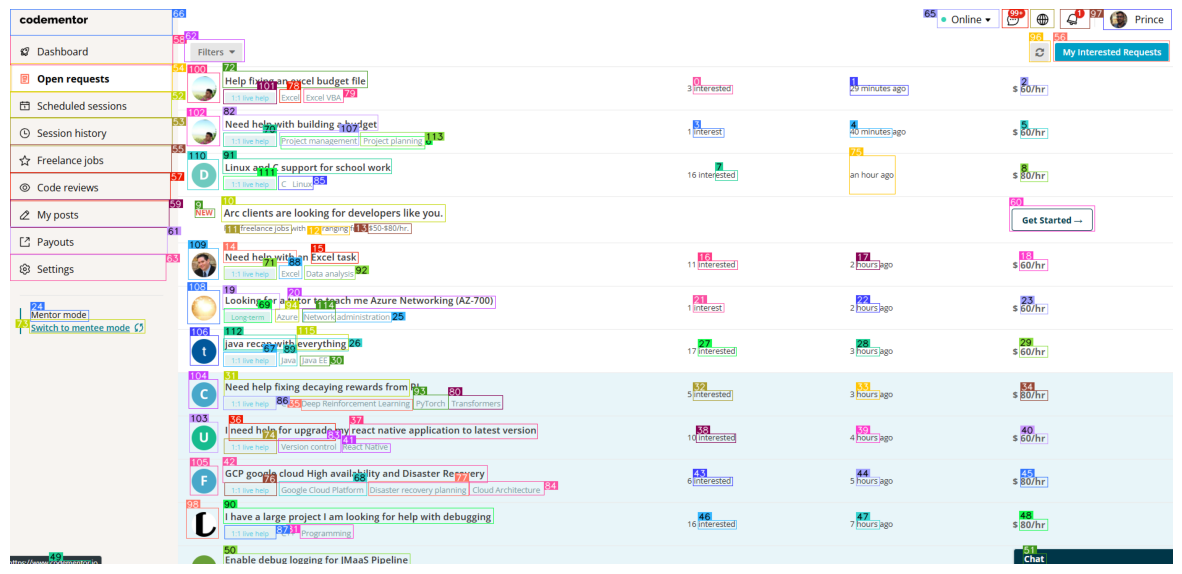

In [28]:
# plot dino_labled_img it is in base64
import base64
import matplotlib.pyplot as plt
import io
plt.figure(figsize=(15,15))

image = Image.open(io.BytesIO(base64.b64decode(dino_labled_img)))
plt.axis('off')

plt.imshow(image)
# print(len(parsed_content_list))


In [29]:
import pandas as pd
df = pd.DataFrame(parsed_content_list)
df['ID'] = range(len(df))

df

,type,bbox,interactivity,content,source,ID
0,text,"[0.5871413350105286, 0.13697104156017303, 0.62...",False,interested,box_ocr_content_ocr,0
1,text,"[0.7221041321754456, 0.13697104156017303, 0.77...",False,29 minutes ag0,box_ocr_content_ocr,1
2,text,"[0.8687566518783569, 0.13697104156017303, 0.89...",False,60/hr,box_ocr_content_ocr,2
3,text,"[0.5871413350105286, 0.21492205560207367, 0.61...",False,interest,box_ocr_content_ocr,3
4,text,"[0.7221041321754456, 0.21492205560207367, 0.75...",False,40 minutes,box_ocr_content_ocr,4
...,...,...,...,...,...,...
111,icon,"[0.18353772163391113, 0.30077382922172546, 0.2...",True,a live help or link.,box_yolo_content_yolo,111
112,icon,"[0.1841997504234314, 0.5870330929756165, 0.245...",True,Save with,box_yolo_content_yolo,112
113,icon,"[0.30134087800979614, 0.222375750541687, 0.356...",True,Projecting,box_yolo_content_yolo,113
114,icon,"[0.2513830363750458, 0.54081130027771, 0.27980...",True,Network,box_yolo_content_yolo,114


In [30]:
parsed_content_list

[{'type': 'text',
  'bbox': [0.5871413350105286,
   0.13697104156017303,
   0.6211476922035217,
   0.1525612473487854],
  'interactivity': False,
  'content': 'interested',
  'source': 'box_ocr_content_ocr'},
 {'type': 'text',
  'bbox': [0.7221041321754456,
   0.13697104156017303,
   0.7720510363578796,
   0.15478841960430145],
  'interactivity': False,
  'content': '29 minutes ag0',
  'source': 'box_ocr_content_ocr'},
 {'type': 'text',
  'bbox': [0.8687566518783569,
   0.13697104156017303,
   0.8921360373497009,
   0.15478841960430145],
  'interactivity': False,
  'content': '60/hr',
  'source': 'box_ocr_content_ocr'},
 {'type': 'text',
  'bbox': [0.5871413350105286,
   0.21492205560207367,
   0.6137087941169739,
   0.23051224648952484],
  'interactivity': False,
  'content': 'interest',
  'source': 'box_ocr_content_ocr'},
 {'type': 'text',
  'bbox': [0.7221041321754456,
   0.21492205560207367,
   0.7582359313964844,
   0.23051224648952484],
  'interactivity': False,
  'content': '40 